In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import imageio as io
import os

#ficheiros .py acessórios
import automatic_patching as patcher
import utils
import generate_data as generator
import evaluator as evaluator
import models as modeling_tool

# Step-by-step

In [ ]:
patient_number = 14

In [ ]:
patient_folder = "patients/patient_{}/".format(patient_number)

In [ ]:
le = LabelEncoder()
ground_truth_csv = pd.read_csv('patients/patient_gt.csv')
df_list = [df for df in ground_truth_csv.groupby('patient')]
for df in df_list:
    if 'patient_{}'.format(patient_number) == df[0]:
        gt = list(df[1]['label'])[0]
        patient_df = df[1]
        patient_df = patient_df.reset_index()
        density = list(df[1]['density'])[0]

### Show mammograms

In [ ]:
print('Patient {} | {} | Density: {}'.format(patient_number,gt,density))
patcher.show_mammograms(patient_folder)

### Show binary mammogram

In [ ]:
patcher.show_binarized(patient_folder)

### Show number of patches

In [ ]:
patch_size = 300
overlap = 0.2

In [ ]:
patcher.patches_number(patient_folder)

### Show patch sides and centers

In [ ]:
patcher.show_sides(patient_folder)

In [ ]:
patcher.show_centers(patient_folder,patch_size)

## Classification

### without Data Augmentation

In [ ]:
try:
    loaded_model = keras.models.load_model("D:/Lesion-Based Patches/vgg19_trained",compile=True)
except OSError:
    print("Failed to load DL model!") 
else:
    print("Successfully loaded DL model!")

In [ ]:
loaded_model.summary()

### Classify patches by image

In [ ]:
predictions_d = dict()
image_paths = os.listdir(patient_folder)
not_images = []
for image in image_paths:
    if 't' in image:
        not_images.append(image)
for image in not_images:
    image_paths.remove(image)
for image in image_paths:
    path = patient_folder+image
    patches_paths = patcher.save_patches_by_image(path,patch_size,overlap)
    df = pd.DataFrame({'paths':patches_paths,'labels':'Test'})
    generated_data = generator.generate(df,patch_size)
    predictions = loaded_model.predict(generated_data,verbose=1)
    print("Successfully classified patches!")
    print('\n')
    predictions_image=[]
    for i in range(len(predictions)):
        predictions_image.append(predictions[i][0])
    predictions_d[image] = predictions_image

In [ ]:
print('Patient {} | {} | Density: {}'.format(patient_number,gt,density))
for image_view,i_classifications in predictions_d.items():
    image_view = image_view.split('.')[0]
    ratios = []
    num_patches = len(i_classifications)
    positive_patches = 0
    for pred in i_classifications:
        if pred > 0.95:
            positive_patches += 1
    ratio = positive_patches/num_patches
    ratios.append(ratio)
    print(image_view +': Patches {} | Positive Patches {} | Ratio {:.2f}'.format(num_patches,positive_patches,ratio))
#print('Average Ratio: ',round(average_ratio(ratios),2))

### Clasify patches by case

In [ ]:
patches_paths = patcher.save_patches_by_case(patient_folder,patch_size,overlap)

In [ ]:
df = pd.DataFrame({'paths':patches_paths,'labels':'Test'})
generated_data = generator.generate(df,patch_size)

In [ ]:
predictions = loaded_model.predict(generated_data,verbose=1)
print("Successfully classified patches!")
predictions_case=[]
for i in range(len(predictions)):
    predictions_case.append(predictions[i][0])

In [ ]:
print('Patient {} | {} | Density: {}'.format(patient_number,gt,density))
num_patches = len(predictions_case)
positive_patches = 0
for pred in predictions_case:
    if pred > 0.95:
        positive_patches += 1
ratio = positive_patches/num_patches
print('Patches {} | Positive Patches {} | Ratio {:.3f}'.format(num_patches,positive_patches,ratio))

In [ ]:
evaluator.make_hist(predictions_case,patient_number,gt)

In [ ]:
patcher.show_positive_patches_on_mammography(patient_folder,patch_size,overlap,predictions_case,patient_df)

In [ ]:
0/0

# 1º - Verification Step

In [ ]:
utils.integrity_check()

# 2º - Patching

In [ ]:
patch_size = 300
overlap = 0.2

In [ ]:
patcher.save_patches_by_image(patch_size,overlap)

# 3º - Classification

## Patch Classification

### VGG Model

In [ ]:
try:
    loaded_model = keras.models.load_model("D:/Lesion-Based Patches/vgg19_trained")
except OSError:
    print("Failed to load DL model!") 
else:
    print("Successfully loaded DL model!")

In [ ]:
modeling_tool.classify_patches_transfer(loaded_model)

In [4]:
threshold = 0.15
transfer = True

In [ ]:
evaluator.report_by_image(threshold,transfer)
evaluator.report_by_case(threshold,transfer)

In [ ]:
evaluator.overlay_percentage(300,0.15,True)

### From-Scratch

In [ ]:
try:
    loaded_model = keras.models.load_model("D:/Lesion-Based Patches/from_scratch_weighted.h5")
except OSError:
    print("Failed to load DL model!") 
else:
    print("Successfully loaded DL model!")

In [ ]:
loaded_model.summary()

In [ ]:
modeling_tool.classify_patches_from_scratch(loaded_model)

In [ ]:
transfer = False
threshold = 0.5

In [ ]:
evaluator.report_by_image(threshold,transfer)
evaluator.report_by_case(threshold,transfer)

## Image Classification

In [ ]:
auc = 0.90
evaluator.classify_images(auc,transfer)

In [ ]:
evaluator.overlay_percentage(patch_size,transfer,threshold)

## Case Classification

In [ ]:
evaluator.classify_cases(transfer)

# 4º - Result Analysis

## Overall

### Image Report

In [ ]:
a = pd.read_csv('results tf/classification_report_by_image.csv')
a.head(40)

### Case Report

In [ ]:
a = pd.read_csv('results tf/classification_report_by_case.csv')
a.head(30)

### AUC by case

In [ ]:
auc,accuracy,df,c = evaluator.evaluate_predictions_case(transfer)
print('AUC: {:.3f}'.format(auc))
print('Accuracy: {:.3f}'.format(accuracy))
print('True Negatives:',c[0][0])
print('False Positives:',c[0][1])
print('True Positives:',c[1][1])
print('False Negatives:',c[1][0])

### AUC by image

In [ ]:
auc,accuracy,fpr,tpr,df,c = evaluator.evaluate_predictions_image(transfer)
print('AUC: {:.3f}'.format(auc))
print('Accuracy: {:.3f}'.format(accuracy))
print('True Negatives:',c[0][0])
print('False Positives:',c[0][1])
print('True Positives:',c[1][1])
print('False Negatives:',c[1][0])
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)

## By patient

In [15]:
patient_number = 7

### Report

In [12]:
report = evaluator.patient_report(patient_number,transfer)
report.head(20)

,Patient,Age,Ground Truth,Density,Lesion,Image View,Area Factor,Patches,Suspicious,Classification,Overlay
2,Patient 2,60.0,Suspicious,3,mass+calc,LCC,26.3,135,18,Suspicious,0.0
3,Patient 2,60.0,Suspicious,3,mass+calc,LCC2,26.3,141,26,Suspicious,0.0
4,Patient 2,60.0,Suspicious,3,mass+calc,LO,39.1,133,17,Suspicious,0.0
5,Patient 2,60.0,Suspicious,3,mass+calc,LO1,39.1,128,10,Normal,0.0


## Histogram

In [ ]:
evaluator.make_hist(patient_number)

## Suspicious Patches

In [13]:
patch_size = 300
overlap = 0.2

In [23]:
patient_number = 10

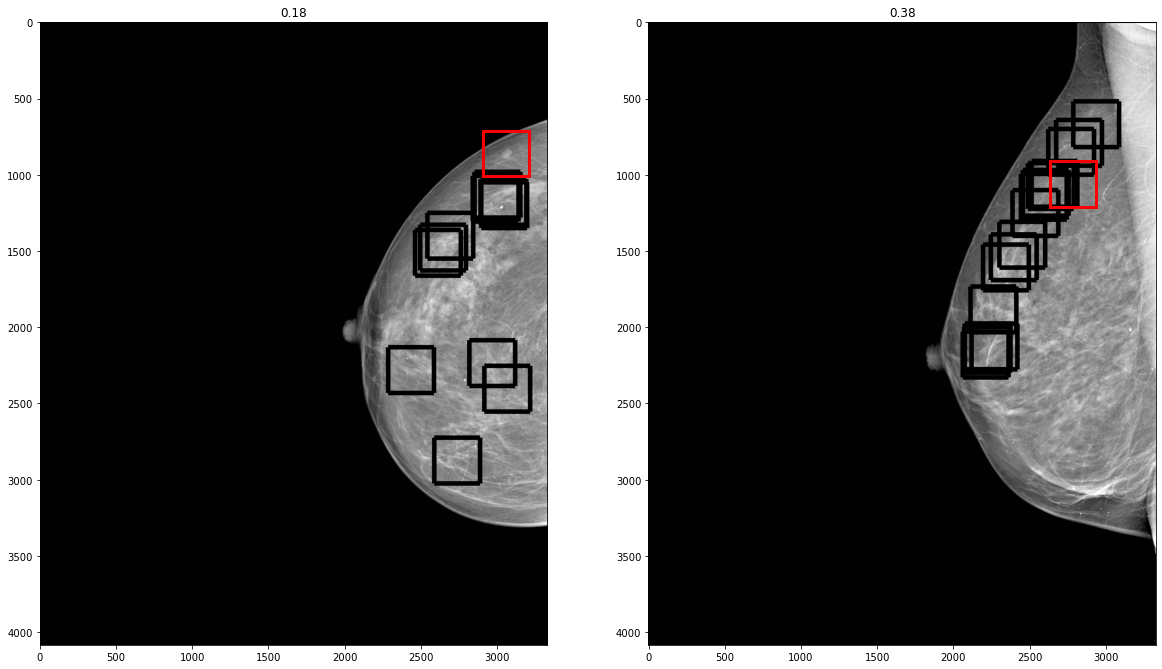

In [24]:
a =patcher.show_positive_patches_on_mammography(patient_number,patch_size,overlap,threshold)

In [2]:
patient_folder = "patients/"
patient_paths = os.listdir(patient_folder)
not_folders = []
for image in patient_paths:
    if 'g' in image:
        not_folders.append(image)
for image in not_folders:
    patient_paths.remove(image)
patient_paths = utils.sort_paths(patient_paths)

final_list = []
for patient in patient_paths:
    patient_list = patcher.overlay_patient(patient)
    if len(patient_list) > 0:
        final_list.append(float("{:.2f}".format(sum(patient_list)/len(patient_list))))

No suspicious patches detected!
No suspicious patches detected!
No suspicious patches detected!


In [3]:
final_list

[0.0,
 0.32,
 0.35,
 0.15,
 0.32,
 0.47,
 0.28,
 0.13,
 0.5,
 0.32,
 0.17,
 0.5,
 0.23,
 0.0,
 0.0,
 0.24,
 0.42,
 0.14,
 0.04,
 0.14,
 0.06,
 0.22,
 0.59,
 0.12,
 0.0,
 0.54,
 0.12,
 0.15,
 0.0,
 0.13,
 0.16,
 0.33,
 0.16,
 0.12,
 0.37,
 0.06,
 0.14,
 0.15,
 0.09,
 0.43,
 0.25,
 0.46,
 0.0,
 0.41,
 0.58,
 0.03,
 0.38,
 0.34,
 0.07,
 0.2,
 0.59,
 0.15,
 0.42,
 0.34,
 0.67,
 0.25,
 0.21,
 0.0,
 0.25,
 0.62,
 0.59,
 0.22,
 0.16,
 0.6,
 0.04,
 0.2,
 0.09,
 0.17,
 0.09,
 0.09,
 0.46,
 0.37]